In [28]:
# Import libraries and set parameters

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller

print("Numpy version", np.__version__)
print("Pandas version", pd.__version__)
print("Seaborn version", sns.__version__)

Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [12]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum() / len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100

    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me, rmse, mape, wape))

In [29]:
import pandas as pd

pm25_patient = pd.read_csv("pm25_patient.csv", header=0, index_col=0, parse_dates=True)

In [31]:
pm25_patient.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82871 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   province    82871 non-null  object 
 1   no_patient  82871 non-null  int64  
 2   pm25        72349 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ MB


In [15]:
# # คำนวณค่าเฉลี่ยของคอลัมน์ no_patient
# mean_value = pm25_patient['no_patient'].mean()

# # เติมข้อมูลค่าว่างในคอลัมน์ no_patient ด้วยค่าเฉลี่ย
# pm25_patient['no_patient'].fillna(mean_value, inplace=True)

In [ ]:
pm25_patient

In [32]:
# เติมค่าที่หายไปในคอลัมน์ pm25 ด้วย interpolation
pm25_patient["pm25"] = pm25_patient["pm25"].interpolate(method="linear")

In [33]:
pm25_patient.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82871 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   province    82871 non-null  object 
 1   no_patient  82871 non-null  int64  
 2   pm25        82871 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ MB


In [34]:
pm25_patient.sort_index(ascending=True)

,province,no_patient,pm25
date,,,
2020-01-01,กรุงเทพมหานคร,18,20.666667
2020-01-01,กาญจนบุรี,12,38.000000
2020-01-01,ขอนแก่น,36,20.000000
2020-01-01,ฉะเชิงเทรา,13,15.000000
2020-01-01,ชลบุรี,21,23.000000
...,...,...,...
2023-12-31,อ่างทอง,1,45.600000
2023-12-31,เชียงใหม่,1,20.650000
2023-12-31,เพชรบูรณ์,1,23.000000


In [39]:
# สร้าง dictionary เพื่อเก็บข้อมูลแยกตามจังหวัด
province_data = {}

# รายการจังหวัดทั้งหมดใน DataFrame
provinces = pm25_patient["province"].unique()

# แยกข้อมูลตามจังหวัด
for province in provinces:
    province_data[province] = pm25_patient[pm25_patient["province"] == province]

# ตัวอย่างการเข้าถึงข้อมูลของจังหวัดใดจังหวัดหนึ่ง เช่น กรุงเทพมหานคร
bangkok_data = province_data["กรุงเทพมหานคร"]
print(bangkok_data.head())

                 province  no_patient       pm25
date                                            
2020-01-01  กรุงเทพมหานคร          18  20.666667
2020-01-02  กรุงเทพมหานคร          69  25.583333
2020-01-03  กรุงเทพมหานคร          53  29.833333
2020-01-04  กรุงเทพมหานคร          14  36.583333
2020-01-05  กรุงเทพมหานคร          13  41.750000


In [63]:
pmbkk_Y = pd.Series(bangkok_data["pm25"])
print(pmbkk_Y.head())

date
2020-01-01    20.666667
2020-01-02    25.583333
2020-01-03    29.833333
2020-01-04    36.583333
2020-01-05    41.750000
Name: pm25, dtype: float64


In [64]:
pmbkk_X = pd.Series(bangkok_data["no_patient"])
print(pmbkk_X.head())

date
2020-01-01    18
2020-01-02    69
2020-01-03    53
2020-01-04    14
2020-01-05    13
Name: no_patient, dtype: int64


<Axes: xlabel='date'>

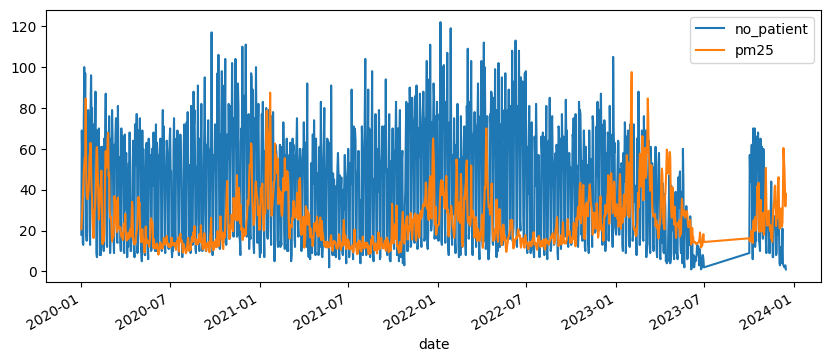

In [40]:
bangkok_data.plot(figsize=(10, 4))

In [42]:
print("Results of Augmented Dickey-Fuller Test:")
dftest = adfuller(pmbkk_Y)
dfoutput = pd.Series(dftest[0:2], index=["Test Statistic", "p-value"])
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic   -5.550461
p-value           0.000002
dtype: float64


In [65]:
print("Results of Augmented Dickey-Fuller Test:")
dftest = adfuller(pmbkk_X)
dfoutput = pd.Series(dftest[0:2], index=["Test Statistic", "p-value"])
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic   -2.971809
p-value           0.037612
dtype: float64


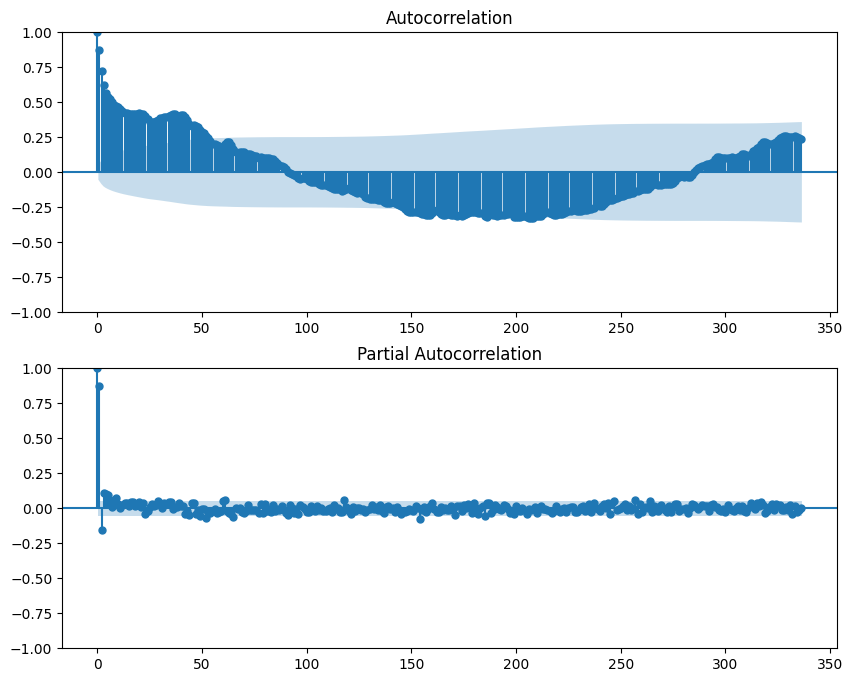

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = max(10, len(pmbkk_Y) / 4)
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plot_acf(pmbkk_Y, lags=max_lag, ax=ax1)
plot_pacf(pmbkk_Y, lags=max_lag, ax=ax2)

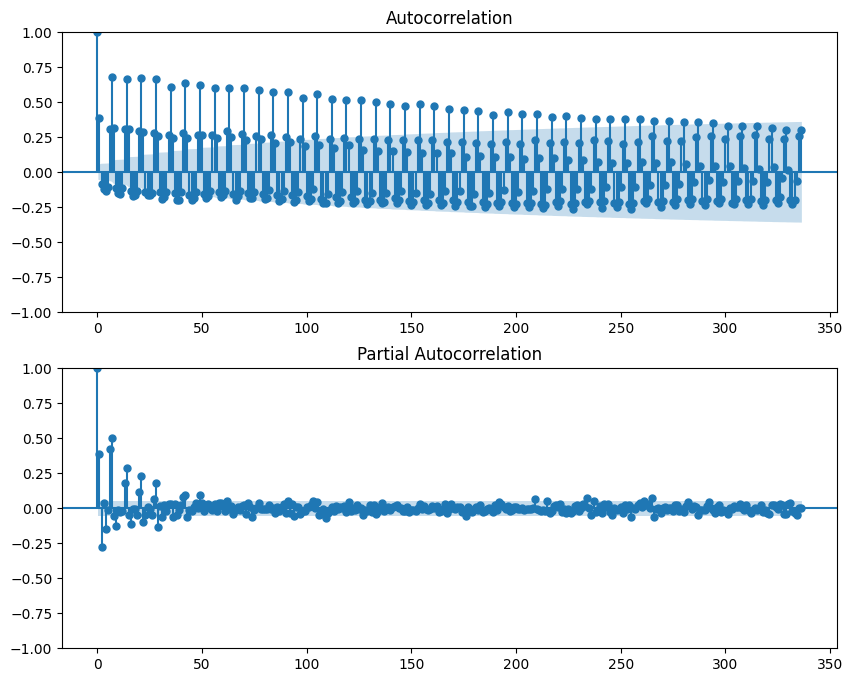

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = max(10, len(pmbkk_X) / 4)
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plot_acf(pmbkk_X, lags=max_lag, ax=ax1)
plot_pacf(pmbkk_X, lags=max_lag, ax=ax2)

In [52]:
split_ratio = 0.7
train_size = int(len(pmbkk_Y) * split_ratio)
Y_train, Y_test = pmbkk_Y[:train_size], pmbkk_Y[train_size:]

In [53]:
pdq = (0, 0, 3)
pmbkk_model = SARIMAX(Y_train, order=pdq, trend="c").fit(disp=False)

In [54]:
print(pmbkk_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   pm25   No. Observations:                  941
Model:               SARIMAX(0, 0, 3)   Log Likelihood               -3086.319
Date:                Sun, 14 Jul 2024   AIC                           6182.638
Time:                        15:50:56   BIC                           6206.872
Sample:                             0   HQIC                          6191.876
                                - 941                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     23.3857      0.814     28.733      0.000      21.790      24.981
ma.L1          1.0540      0.021     49.250      0.000       1.012       1.096
ma.L2          0.7850      0.031     25.644      0.0

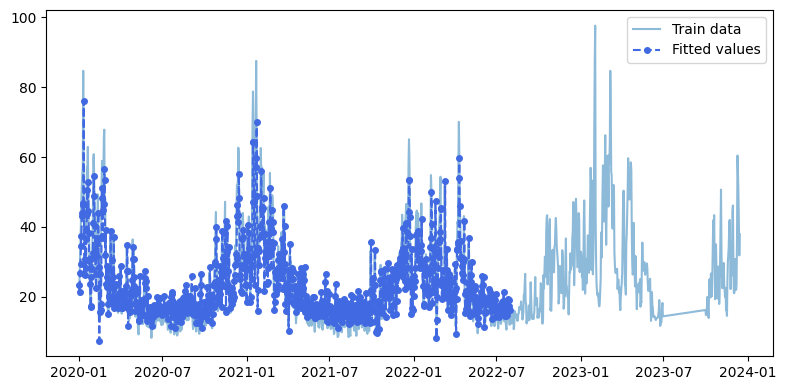

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(pmbkk_Y, alpha=0.5, label="Train data")
plt.plot(
    pmbkk_model.fittedvalues, "--o", color="royalblue", ms=4, label="Fitted values"
)
plt.legend(loc="best")
plt.tight_layout()

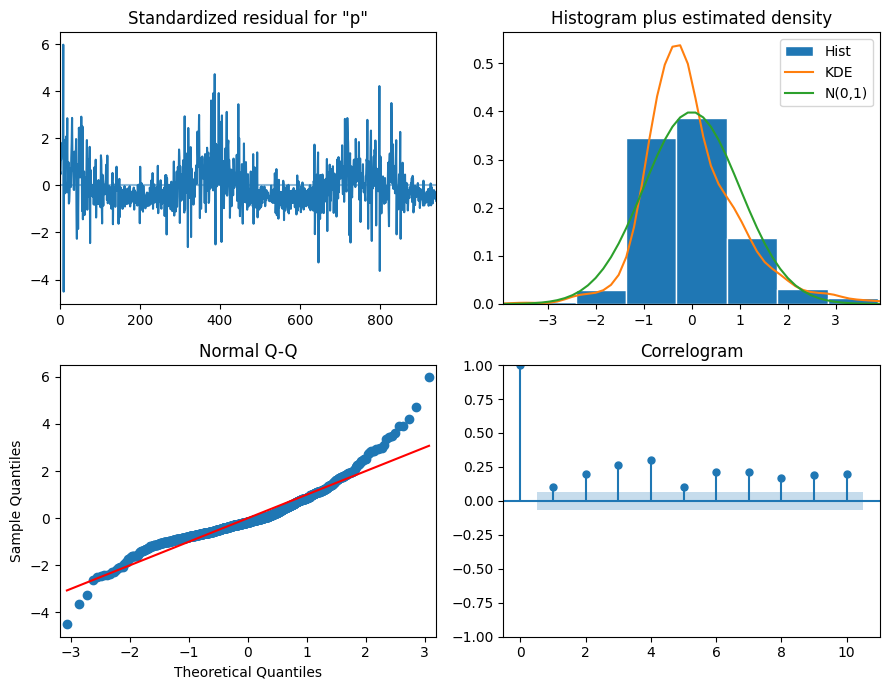

In [57]:
pmbkk_model.plot_diagnostics(figsize=(9, 7))
plt.tight_layout()

In [58]:
from statsmodels.stats.diagnostic import acorr_ljungbox

x = pmbkk_model.resid
h = min(10, int(len(x) / 5))
lb_result = acorr_ljungbox(x, lags=h)
print(lb_result)

       lb_stat     lb_pvalue
1    10.023838  1.545271e-03
2    45.994455  1.029037e-10
3   113.522012  1.915423e-24
4   198.448373  8.099457e-42
5   207.798192  6.091610e-43
6   251.840280  1.658197e-51
7   295.016859  7.010381e-60
8   321.725046  9.719224e-65
9   354.753551  6.030386e-71
10  392.635768  3.473346e-78


In [59]:
history = [y for y in Y_train]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 1
for t in range(len(Y_test) - (h - 1)):

    model_fit = SARIMAX(train, order=pdq, trend="c").fit(disp=False)

    output = model_fit.get_forecast(h)
    predictions.append(output.predicted_mean[h - 1])
    lower_ci.append(output.conf_int()[h - 1, 0])
    upper_ci.append(output.conf_int()[h - 1, 1])

    history.append(Y_test.iloc[t])
    train = history[t + 1 :]

ME: 1.48, RMSE: 7.72, MAPE: 19.04%, WAPE: 19.19%


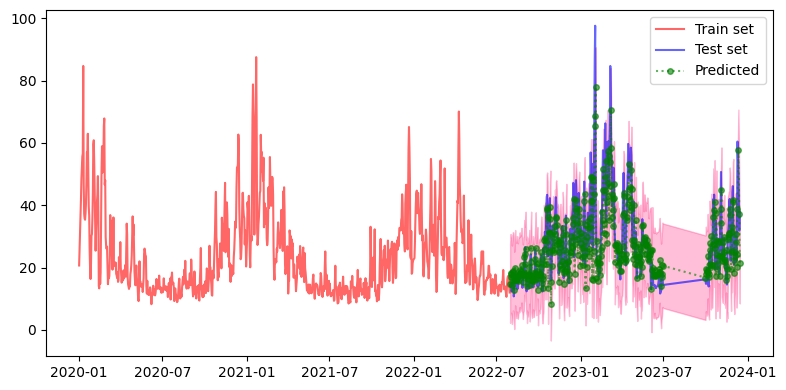

In [60]:
plt.figure(figsize=(8, 4))
plt.plot(Y_train, label="Train set", color="red", alpha=0.6)
plt.plot(Y_test, label="Test set", color="blue", alpha=0.6)

predictions = pd.Series(predictions, index=Y_test.index[h - 1 :])
plt.plot(predictions, "go:", label="Predicted", alpha=0.6, ms=4)
plt.fill_between(Y_test.index[h - 1 :], upper_ci, lower_ci, color="#ff0066", alpha=0.25)
plt.legend(loc="best")
plt.tight_layout()

get_forecast_accuracy(Y_test[h - 1 :], predictions)

In [18]:
# ฟังก์ชันสำหรับทำนาย pm25 และ no_patient โดยแยกตาม province
def forecast_province(pm25_patient, province):
    df_province = pm25_patient[pm25_patient["province"] == province]
    # แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
    train_size = int(len(df_province) * 0.8)
    train, test = df_province.iloc[:train_size], df_province.iloc[train_size:]

    # ทำนายค่า pm25
    sarimax_pm25 = SARIMAX(train["pm25"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_pm25 = sarimax_pm25.fit(disp=False)
    forecast_pm25 = results_pm25.predict(start=test.index[0], end=test.index[-1])
    aic_pm25 = results_pm25.aic

    # รวมค่าทำนาย pm25 กับข้อมูลทดสอบ
    test["forecasted_pm25"] = forecast_pm25

    # ทำนายค่า no_patient โดยใช้ pm25 ที่ทำนายได้
    sarimax_no_patient = SARIMAX(
        train["no_patient"],
        exog=train[["pm25"]],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
    )
    results_no_patient = sarimax_no_patient.fit(disp=False)
    forecast_no_patient = results_no_patient.predict(
        start=test.index[0], end=test.index[-1], exog=test[["forecasted_pm25"]]
    )
    aic_no_patient = results_no_patient.aic

    # แสดงผลการทำนายและค่า AIC
    print(f"Province: {province}")
    print(f"AIC for pm25 model: {aic_pm25}")
    print(f"AIC for no_patient model: {aic_no_patient}")

    # แสดงกราฟผลการทำนาย
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test["pm25"], label="Actual pm25")
    plt.plot(
        test.index, test["forecasted_pm25"], label="Forecasted pm25", linestyle="--"
    )
    plt.plot(test.index, test["no_patient"], label="Actual no_patient")
    plt.plot(
        test.index, forecast_no_patient, label="Forecasted no_patient", linestyle="--"
    )
    plt.title(f"Forecast for {province}")
    plt.legend()
    plt.show()


# เรียกฟังก์ชันสำหรับแต่ละ province
provinces = pm25_patient["province"].unique()
for province in provinces:
    forecast_province(pm25_patient, province)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

ADF Statistic: -3.2907773656271315
p-value: 0.015295793511334848
Critial Values:
   1%, -3.436557639266102
Critial Values:
   5%, -2.8642808573632874
Critial Values:
   10%, -2.5682293371570823
ADF Statistic: -4.104463679315061
p-value: 0.0009522006189243313
Critial Values:
   1%, -3.4365694473419928
Critial Values:
   5%, -2.8642860655788693
Critial Values:
   10%, -2.568232111086707
Province: กรุงเทพมหานคร
AIC for pm25 model: 6892.90154469021
AIC for no_patient model: 9958.93646923167


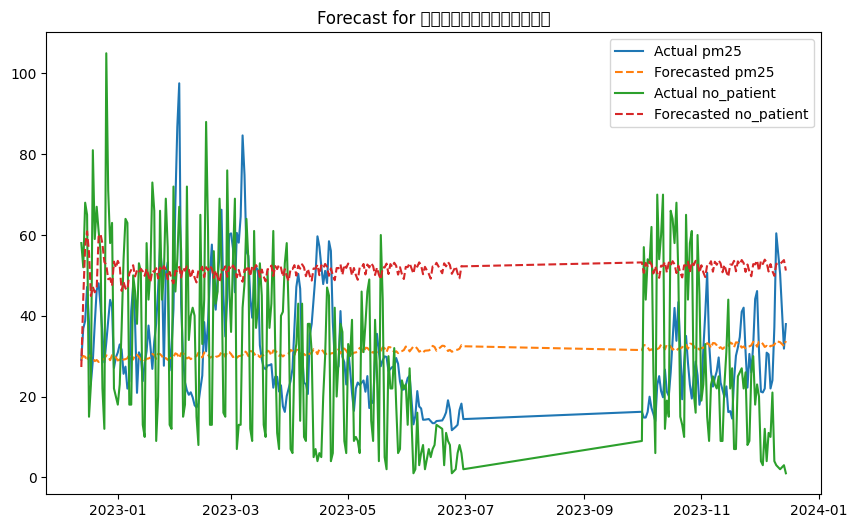

ADF Statistic: -3.2027337428642264
p-value: 0.019826983770128523
Critial Values:
   1%, -3.4360490926821727
Critial Values:
   5%, -2.8640565321870635
Critial Values:
   10%, -2.5681098631379964
ADF Statistic: -2.9381525898181557
p-value: 0.04108786346332095
Critial Values:
   1%, -3.436089106551049
Critial Values:
   5%, -2.864074184091338
Critial Values:
   10%, -2.568119264202968
Province: กาญจนบุรี
AIC for pm25 model: 7712.232921228345
AIC for no_patient model: 10135.737505706627


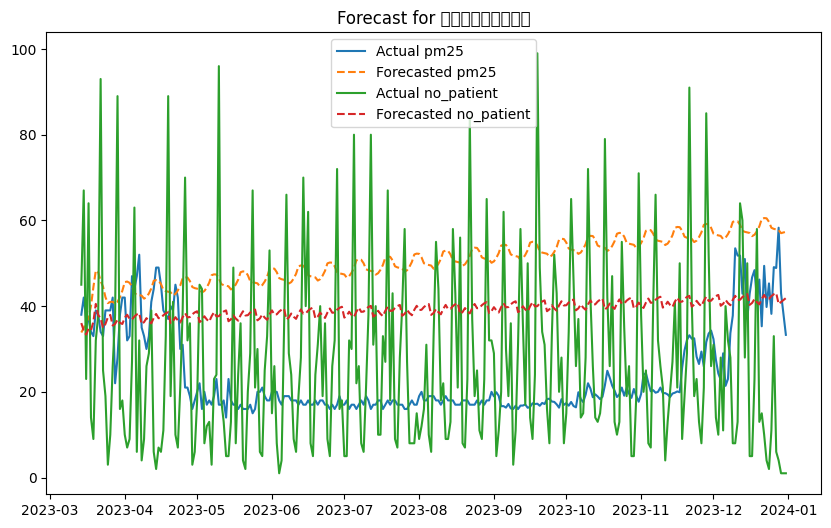

ADF Statistic: -2.8180432736185193
p-value: 0.05574227879722659
Critial Values:
   1%, -3.4360690296267338
Critial Values:
   5%, -2.864065327292836
Critial Values:
   10%, -2.568114547237679
ADF Statistic: -4.629322597994662
p-value: 0.00011401459252877216
Critial Values:
   1%, -3.4360740356772745
Critial Values:
   5%, -2.864067535683479
Critial Values:
   10%, -2.5681157233843748


MissingDataError: exog contains inf or nans

In [27]:
# ฟังก์ชันสำหรับตรวจสอบ stationarity ด้วย ADF test
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print("Critial Values:")
        print(f"   {key}, {value}")

    return result[1] <= 0.05  # return True if p-value is less than 0.05


# ฟังก์ชันสำหรับทำนาย pm25 และ no_patient โดยแยกตาม province
def forecast_province(pm25_patient, province):
    df_province = pm25_patient[pm25_patient["province"] == province]

    # แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
    train_size = int(len(df_province) * 0.8)
    train, test = df_province.iloc[:train_size], df_province.iloc[train_size:]

    # ตรวจสอบ stationarity และทำ differencing ถ้าจำเป็น
    if not check_stationarity(train["pm25"]):
        train["pm25"] = train["pm25"].diff().dropna()
        test["pm25"] = test["pm25"].diff().dropna()
    if not check_stationarity(train["no_patient"]):
        train["no_patient"] = train["no_patient"].diff().dropna()
        test["no_patient"] = test["no_patient"].diff().dropna()

    # เติมค่าที่หายไปใน train และ test เพื่อให้แน่ใจว่าไม่มี NaN หรือ inf
    train.fillna(method="ffill", inplace=True)
    test.fillna(method="ffill", inplace=True)

    # ทำนายค่า pm25
    sarimax_pm25 = SARIMAX(train["pm25"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_pm25 = sarimax_pm25.fit(disp=False)

    # ตรวจสอบค่า start และ end เพื่อการทำนาย
    start = len(train)
    end = start + len(test) - 1

    forecast_pm25 = results_pm25.predict(start=start, end=end)
    aic_pm25 = results_pm25.aic

    # รวมค่าทำนาย pm25 กับข้อมูลทดสอบ
    test["forecasted_pm25"] = forecast_pm25.values

    # ทำนายค่า no_patient โดยใช้ pm25 ที่ทำนายได้
    sarimax_no_patient = SARIMAX(
        train["no_patient"],
        exog=train[["pm25"]],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
    )
    results_no_patient = sarimax_no_patient.fit(disp=False)

    forecast_no_patient = results_no_patient.predict(
        start=start, end=end, exog=test[["forecasted_pm25"]]
    )
    aic_no_patient = results_no_patient.aic

    # แสดงผลการทำนายและค่า AIC
    print(f"Province: {province}")
    print(f"AIC for pm25 model: {aic_pm25}")
    print(f"AIC for no_patient model: {aic_no_patient}")

    # แสดงกราฟผลการทำนาย
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test["pm25"], label="Actual pm25")
    plt.plot(
        test.index, test["forecasted_pm25"], label="Forecasted pm25", linestyle="--"
    )
    plt.plot(test.index, test["no_patient"], label="Actual no_patient")
    plt.plot(
        test.index, forecast_no_patient, label="Forecasted no_patient", linestyle="--"
    )
    plt.title(f"Forecast for {province}")
    plt.legend()
    plt.show()


# เรียกฟังก์ชันสำหรับแต่ละ province
provinces = pm25_patient["province"].unique()
for province in provinces:
    forecast_province(pm25_patient, province)

In [ ]:
df_province

In [ ]:
# ทำนายค่า pm25
best_model_pm25, best_order_pm25, best_seasonal_order_pm25 = grid_search_sarimax(
    train["pm25"], test["pm25"]
)
forecast_pm25 = best_model_pm25.predict(start=test.index[0], end=test.index[-1])

# # รวมค่าทำนาย pm25 กับข้อมูลทดสอบ
# test['forecasted_pm25'] = forecast_pm25

# # ทำนายค่า no_patient โดยใช้ pm25 ที่ทำนายได้
# best_model_no_patient, best_order_no_patient, best_seasonal_order_no_patient = grid_search_sarimax(train['no_patient'], test['no_patient'], exog_train=train[['pm25']], exog_test=test[['forecasted_pm25']])
# forecast_no_patient = best_model_no_patient.predict(start=test.index[0], end=test.index[-1], exog=test[['forecasted_pm25']])

# # แสดงผลการทำนายและค่า AIC
# print(f'Province: {province}')
# print(f'AIC for pm25 model: {best_model_pm25.aic}')
# print(f'AIC for no_patient model: {best_model_no_patient.aic}')

# # แสดงกราฟผลการทำนาย
# plt.figure(figsize=(10, 6))
# plt.plot(test.index, test['pm25'], label='Actual pm25')
# plt.plot(test.index, test['forecasted_pm25'], label='Forecasted pm25', linestyle='--')
# plt.plot(test.index, test['no_patient'], label='Actual no_patient')
# plt.plot(test.index, forecast_no_patient, label='Forecasted no_patient', linestyle='--')
# plt.title(f'Forecast for {province}')
# plt.legend()
# plt.show()

# # เรียกฟังก์ชันสำหรับแต่ละ province
# provinces = pm25_patient['province'].unique()
# for province in provinces:
#     forecast_province(pm25_patient, province)

In [ ]:
# # ฟังก์ชันสำหรับทำนาย pm25 และ no_patient โดยแยกตาม province
# def forecast_province(pm25_patient,province):
#     pm25_patient = pm25_patient[pm25_patient['province'] == province]


# # ทำนายค่า pm25
# sarimax_pm25 = SARIMAX(df_province['pm25'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
# results_pm25 = sarimax_pm25.fit(disp=False)
# forecast_pm25 = results_pm25.predict(start=len(df_province), end=len(df_province)+10)

# #     # สร้าง DataFrame สำหรับค่าทำนาย pm25
# #     future_dates = pd.date_range(start=df_province.index[-1], periods=11, freq='D')
# #     df_forecast_pm25 = pd.DataFrame({'date': future_dates[1:], 'pm25': forecast_pm25})
# #     df_forecast_pm25.set_index('date', inplace=True)

# #     # รวมค่าทำนาย pm25 กับข้อมูลเดิม
#     df_combined = pd.concat([df_province, df_forecast_pm25])

#     # ทำนายค่า no_patient โดยใช้ pm25 ที่ทำนายได้
#     sarimax_no_patient = SARIMAX(df_combined['no_patient'], exog=df_combined['pm25'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
#     results_no_patient = sarimax_no_patient.fit(disp=False)
#     forecast_no_patient = results_no_patient.predict(start=len(df_province), end=len(df_province)+10, exog=df_forecast_pm25['pm25'])

#     # แสดงผลการทำนาย
#     print(f'Province: {province}')
#     print('Forecasted pm25:')
#     print(df_forecast_pm25)
#     print('Forecasted no_patient:')
#     print(forecast_no_patient)

#     # แสดงกราฟผลการทำนาย
#     plt.figure(figsize=(10, 6))
#     plt.plot(df_combined.index, df_combined['pm25'], label='Actual pm25')
#     plt.plot(df_forecast_pm25.index, df_forecast_pm25['pm25'], label='Forecasted pm25', linestyle='--')
#     plt.plot(df_combined.index, df_combined['no_patient'], label='Actual no_patient')
#     plt.plot(forecast_no_patient.index, forecast_no_patient, label='Forecasted no_patient', linestyle='--')
#     plt.title(f'Forecast for {province}')
#     plt.legend()
#     plt.show()

# # เรียกฟังก์ชันสำหรับแต่ละ province
# provinces = df['province'].unique()
# for province in provinces:
#     forecast_province(df, province)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
    
    # ทำนายค่า pm25
    sarimax_pm25 = SARIMAX(df_province['pm25'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_pm25 = sarimax_pm25.fit(disp=False)
    forecast_pm25 = results_pm25.predict(start=len(df_province), end=len(df_province)+10)
    
    # สร้าง DataFrame สำหรับค่าทำนาย pm25
    future_dates = pd.date_range(start=df_province.index[-1], periods=11, freq='D')
    df_forecast_pm25 = pd.DataFrame({'date': future_dates[1:], 'pm25': forecast_pm25})
    df_forecast_pm25.set_index('date', inplace=True)
    
    # รวมค่าทำนาย pm25 กับข้อมูลเดิม
    df_combined = pd.concat([df_province, df_forecast_pm25])
    
    # ทำนายค่า no_patient โดยใช้ pm25 ที่ทำนายได้
    sarimax_no_patient = SARIMAX(df_combined['no_patient'], exog=df_combined['pm25'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_no_patient = sarimax_no_patient.fit(disp=False)
    forecast_no_patient = results_no_patient.predict(start=len(df_province), end=len(df_province)+10, exog=df_forecast_pm25['pm25'])
    
    # แสดงผลการทำนาย
    print(f'Province: {province}')
    print('Forecasted pm25:')
    print(df_forecast_pm25)
    print('Forecasted no_patient:')
    print(forecast_no_patient)

    # แสดงกราฟผลการทำนาย
    plt.figure(figsize=(10, 6))
    plt.plot(df_combined.index, df_combined['pm25'], label='Actual pm25')
    plt.plot(df_forecast_pm25.index, df_forecast_pm25['pm25'], label='Forecasted pm25', linestyle='--')
    plt.plot(df_combined.index, df_combined['no_patient'], label='Actual no_patient')
    plt.plot(forecast_no_patient.index, forecast_no_patient, label='Forecasted no_patient', linestyle='--')
    plt.title(f'Forecast for {province}')
    plt.legend()
    plt.show()

# เรียกฟังก์ชันสำหรับแต่ละ province
provinces = df['province'].unique()
for province in provinces:
    forecast_province(df, province)

In [ ]:
pm25_patient_Y = pd.Series(pm25_patient["pm25"])
pm25_patient_X = pd.Series(pm25_patient["no_patient"])
print(pm25_patient_X.head())

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("Results of Augmented Dickey-Fuller Test:")
dftest = adfuller(pm25_patient_Y)
dfoutput = pd.Series(dftest[0:2], index=["Test Statistic", "p-value"])
print(dfoutput)